<a href="https://colab.research.google.com/github/Danpollak/Word2Note/blob/master/Classification%20-%20No%20Embbedings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import tensorflow
import pickle as pk
from tqdm.notebook import tqdm
import statistics
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Embedding, Input, Concatenate
from tensorflow import keras

## Data

In [4]:
class NoteLang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"unk": 0, "SOS": 1, "EOS": 2}
        self.index2word = {0: "unk", 1: "SOS", 2: "EOS"}
        self.note2index = {"unk": 0, "SOS": 1, "EOS": 2}
        self.index2note = {0: "unk", 1: "SOS", 2: "EOS"}
        self.n_words = 3
        self.n_notes = 3

    def addSentence(self, sentence):
        for subword in sentence:
            self.addWord(subword)

    def addWord(self, word):
      subword = word[0]
      note = word[1]

      # insert subwords
      if subword not in self.word2index:
          self.word2index[subword] = self.n_words
          self.index2word[self.n_words] = subword
          self.n_words += 1

      # insert notes
      if note not in self.note2index:
          self.note2index[note] = self.n_notes
          self.index2note[self.n_notes] = note
          self.n_notes += 1

    def check_unk(self, subword, vocabulary):
        if subword in vocabulary:
          return vocabulary[subword]
        else:
          return vocabulary["unk"]

    def sentence2index(self,sentence):
      indexed_sentence = [self.check_unk(subword, self.word2index) for subword in sentence]
      return indexed_sentence

    def note_sentence2index(self,sentence):
      indexed_sentence = [self.check_unk(note, self.note2index) for note in sentence]
      return indexed_sentence

def order_dataset(dataset, max_line_length, train=True):
    features = []
    labels = []
    line_length = 0

    for song in tqdm(dataset):
      line = song[0]
      line_features  = []
      line_label =[]

      line_to_parse = [('SOS', 'SOS')]
      line_to_parse.extend(line)
      line_to_parse.append(('EOS', 'EOS'))

      for subword in line_to_parse:
        line_length+=1
        letter = subword[0]
        line_features.append(letter)
        note = subword[1]
        line_label.append(note)

      # append whole line to dataset
      features.append(line_features)
      labels.append(line_label)

      if train:
        # get max line length
        max_line_length = max(max_line_length, line_length)
        line_length=0
        NoteVocab.addSentence(line_to_parse)

    # encode features and labels
    features = [NoteVocab.sentence2index(line) for line in tqdm(features)]
    labels = [NoteVocab.note_sentence2index(line) for line in tqdm(labels)]

    # buffer features and labels
    features = [np.pad(line, (0,max_line_length - len(line)), constant_values=2) for line in tqdm(features)]
    labels = [np.pad(line, (0,max_line_length - len(line)), constant_values=2) for line in tqdm(labels)]

    # convert to numpy
    features = np.array(features)
    labels = np.array(labels)

    print("printing shapes for sainty check:")
    print(features.shape)
    print(labels.shape)

    print("printing parsed data for sainty check:")
    print(features[0])
    print(labels[0])

    print("Max Line is:")
    print(max_line_length)

    return features, labels, max_line_length

def filter_dataset(ds):
    train_set = ds['train']
    test_set = ds['test']
    
    print("Length Before Filtering is:")
    print("Train: " + str(len(train_set)))
    print("Test: " + str(len(test_set)))

    WINDOW_SIZE = 10
    median = statistics.median([len(song[0]) for song in train_set])
    print("Median Length is: " + str(median))

    train_set = [song for song in train_set if len(song[0]) < median and len(song[0]) > (median - WINDOW_SIZE )]
    test_set = [song for song in test_set if len(song[0]) < median and len(song[0]) > (median - WINDOW_SIZE)]

    print("Length After Filtering is:")
    print("Train: " + str(len(train_set)))
    print("Test: " + str(len(test_set)))

    return train_set, test_set

## Import Data

In [7]:
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/Colab Notebooks/DALI/dali_characters_split.pickle'
#data_path= '/content/drive/My Drive/Colab Notebooks/DALI/dcs.pickle'

NoteVocab = NoteLang('word2note')
max_line_length = 0

with open(data_path, 'rb') as pickle_file:
    ds = pk.load(pickle_file)

train_set, test_set = filter_dataset(ds)

features, labels, max_line_length = order_dataset(train_set, max_line_length)
features_test, labels_test, _ = order_dataset(test_set, max_line_length, False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Length Before Filtering is:
Train: 170725
Test: 42681
Median Length is: 23
Length After Filtering is:
Train: 56358
Test: 14192



printing shapes for sainty check:
(56358, 24)
(56358, 24)
printing parsed data for sainty check:
[ 1  3  4  5  6  7  8  9 10  5  6 11  8  4  6 12  8 13 13 11  6  2  2  2]
[1 3 4 4 5 6 7 7 7 7 5 6 7 7 5 8 9 9 8 9 5 2 2 2]
Max Line is:
24



printing shapes for sainty check:
(14192, 24)
(14192, 24)
printing parsed data for sainty check:
[ 1 12 20 21  9  6  5 20 21  7 13 21 18 15  6 14 24  6 17  8  9 21  6  2]
[ 1 22 23 23 23  5 60 61 61 61 61 61 61 61  5 33 80  5 85 86 86 86  5  2]
Max Line is:
24


## Models

## Sentence2Note LSTM

In [8]:
# Hyperparameters
vocab_size = NoteVocab.n_words
number_of_notes = NoteVocab.n_notes
word_embedding_size = 150
LSTM_embedding_size = 150

Model: "Note_Seq2Seq"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Note_Encoder_Inputs_Word (Input [(None, 24, 1)]      0                                            
__________________________________________________________________________________________________
Note_Decoder_Inputs_Word (Input [(None, 24, 1)]      0                                            
__________________________________________________________________________________________________
Note_Encoder (LSTM)             [(None, 150), (None, 91200       Note_Encoder_Inputs_Word[0][0]   
__________________________________________________________________________________________________
Note_Decoder (LSTM)             [(None, 24, 150), (N 91200       Note_Decoder_Inputs_Word[0][0]   
                                                                 Note_Encoder[0][1]    

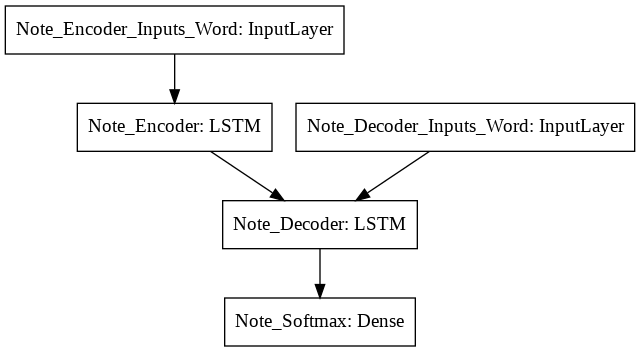

In [9]:
# define note architecture
note_encoder_inputs_word = Input(shape=(max_line_length,1), dtype='float32', name="Note_Encoder_Inputs_Word")
note_decoder_inputs_word = Input(shape=(max_line_length,1), dtype='float32', name="Note_Decoder_Inputs_Word")

# defining LSTM Encoder
note_encoder_LSTM = LSTM(LSTM_embedding_size, return_state=True, name="Note_Encoder")
# getting LSTM Encoder output
_, note_state_h, note_state_c = note_encoder_LSTM(note_encoder_inputs_word)
note_encoder_states = [note_state_h, note_state_c]

# defining LSTM Decoder
note_decoder_LSTM = LSTM(LSTM_embedding_size, return_state=True, return_sequences=True, name="Note_Decoder")
# getting LSTM Decoder output
note_decoder_outputs, _, _ = note_decoder_LSTM(note_decoder_inputs_word, initial_state=note_encoder_states)

# note softmax
note_decoder_dense = Dense(number_of_notes, activation='softmax', name="Note_Softmax")
note_decoder_outputs = note_decoder_dense(note_decoder_outputs)

# model definition for training
model = Model([note_encoder_inputs_word  ,note_decoder_inputs_word], note_decoder_outputs,name="Note_Seq2Seq")

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy') 
          
model.summary()
keras.utils.plot_model(model, expand_nested=True)

## Training

In [10]:
checkpoint_filepath = '/content/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.000001, patience=5, verbose=0, mode='min',
    baseline=None, restore_best_weights=False
)

In [11]:
%%time
# input to encoder is the feature sentence
# input to decoder is the hidden and context vector, and feature sentence
train_metadata = model.fit([features, features], labels,
          batch_size=32,
          epochs=25,
          validation_split=0.3,
          callbacks=[model_checkpoint_callback],
          )
history = train_metadata.history

Epoch 1/25
1233/1233 [==============================] - 11s 9ms/step - loss: 2.4358 - val_loss: 2.2617
Epoch 2/25
1233/1233 [==============================] - 11s 9ms/step - loss: 2.2149 - val_loss: 2.2055
Epoch 3/25
1233/1233 [==============================] - 12s 9ms/step - loss: 2.1878 - val_loss: 2.1941
Epoch 4/25
1233/1233 [==============================] - 11s 9ms/step - loss: 2.1752 - val_loss: 2.1837
Epoch 5/25
1233/1233 [==============================] - 11s 9ms/step - loss: 2.1660 - val_loss: 2.1753
Epoch 6/25
1233/1233 [==============================] - 11s 9ms/step - loss: 2.1582 - val_loss: 2.1736
Epoch 7/25
1233/1233 [==============================] - 11s 9ms/step - loss: 2.1520 - val_loss: 2.1706
Epoch 8/25
1233/1233 [==============================] - 11s 9ms/step - loss: 2.1457 - val_loss: 2.1684
Epoch 9/25
1233/1233 [==============================] - 10s 9ms/step - loss: 2.1402 - val_loss: 2.1732
Epoch 10/25
1233/1233 [==============================] - 11s 9ms/step - l

## Inference

In [17]:
model.load_weights(checkpoint_filepath)

In [13]:
def decode_sequence(features):
    output_tokens = model.predict([features, features])

    # Sample a token
    decoded_sentence = np.squeeze(np.argmax(output_tokens, axis=2))
    print(decoded_sentence.shape)
    print(decoded_sentence)
    sentence = list(map(lambda x : NoteVocab.index2note[x], decoded_sentence))
    return sentence

In [14]:
features[0]

array([ 1,  3,  4,  5,  6,  7,  8,  9, 10,  5,  6, 11,  8,  4,  6, 12,  8,
       13, 13, 11,  6,  2,  2,  2])

In [19]:
instance_id = 0
print(decode_sequence(np.expand_dims(features[instance_id], axis=0)))
print(list(map(lambda x : NoteVocab.index2note[x], labels[instance_id])))

(24,)
[ 1 56 69 69  5 68 69 69 69 69  5 68 69 69  5 68 69 68 69 69  5  2  2  2]
['SOS', 'C5_S', 'A4', 'A4', 'BREAK', 'A4_S', 'A4', 'A4', 'A4', 'A4', 'BREAK', 'A4_S', 'A4', 'A4', 'BREAK', 'A4_S', 'A4', 'A4_S', 'A4', 'A4', 'BREAK', 'EOS', 'EOS', 'EOS']
['SOS', 'A#3_S', 'A#3', 'A#3', 'BREAK', 'D4_S', 'D4', 'D4', 'D4', 'D4', 'BREAK', 'D4_S', 'D4', 'D4', 'BREAK', 'C4_S', 'C4', 'C4', 'C4_S', 'C4', 'BREAK', 'EOS', 'EOS', 'EOS']
